In [9]:
%matplotlib inline
import sys
import os

import matplotlib.pyplot as plt
import scipy
from scipy import io, stats
import pandas as pd
import numpy as np
import math

data = scipy.io.loadmat('mnist_mat.mat')
Xtrain = data['Xtrain']
ytrain = data['ytrain']
Xtest = data['Xtest']
ytest = data['ytest']
Q = data['Q']
d,n = Xtrain.shape
sigma=1.5
Lambda=1.0
#Problem a
def E_pdf(x,w):
    return stats.norm.pdf(-np.dot(x.T, w)/sigma)
def E_cdf(x,w):
    return stats.norm.cdf(-np.dot(x.T, w)/sigma)

def E_STEP(w):
    Xtrain_1 = Xtrain[:, np.where(ytrain==1)[1]]
    Xtrain_0 = Xtrain[:, np.where(ytrain==0)[1]]
    e=np.zeros(n)
    e[np.where(ytrain==1)[1]]=np.dot(Xtrain_1.T,w)+sigma*np.divide(E_pdf(Xtrain_1,w),(1.0-E_cdf(Xtrain_1,w)))
    e[np.where(ytrain==0)[1]]=np.dot(Xtrain_0.T,w)-sigma*np.divide(E_pdf(Xtrain_0,w),E_cdf(Xtrain_0,w))
    return e.reshape(n)

def m_step(E):
    Sumxx=np.sum(np.multiply(Xtrain.T.reshape(n,d,1),Xtrain.T.reshape(n,1,d)),0)/(sigma**2)
    Ephi=np.sum(np.multiply(Xtrain, E.reshape(1,n)), 1)/(sigma**2)
    w=np.dot(np.linalg.inv(Lambda*np.identity(d)+Sumxx),Ephi).reshape(d)
    return w

def W(T):
    w=np.tile(np.zeros((T+1,1)),d)
    E=np.tile(np.zeros((T+1,1)),n)
    for t in range(T):
        E[t+1]=E_STEP(w[t])
        w[t+1]=m_step(E[t+1])
    return w

In [11]:
iteration_100=W(100)

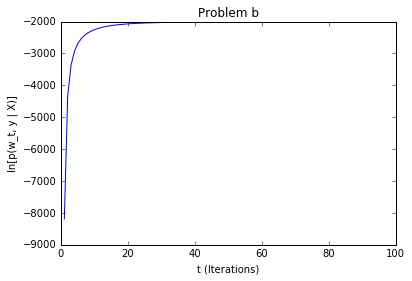

In [21]:
#Problem b
w = iteration_100
lnp=[]
x=[]
for t in range(100):
    X=Xtrain
    y=ytrain
    part_1 = d/2*np.log(Lambda/2/math.pi)
    part_2 = - ((Lambda/2)*np.dot(w[t].T,iteration_100[t]))
    part_3 = np.sum(np.multiply(1-y,np.log(1-stats.norm.cdf(np.dot(X.T,w[t])/sigma))))
    part_4 = np.sum(np.multiply(y,np.log(stats.norm.cdf(np.dot(X.T,w[t])/sigma))))
    lnp.append(part_1 + part_2 + part_3 + part_4)
    x.append(t+1)
    
plt.plot(x, lnp)
plt.title('Problem b')
plt.xlabel(r't (Iterations)')
plt.ylabel(r'ln[p(w_t, y | X)]') 

In [29]:
#Problem c
w=iteration_100
pr=stats.norm.cdf(np.dot(Xtest.T,w[100])/sigma)
k=len(pr)
y_predict=np.zeros(k)
y_predict[np.where(pr>=.5)]=1
y_predict[np.where(pr<.5)]=0

tp=0
fn=0
fp=0
tn=0

for i in range(len(ytest[0])):
    if ytest[0][i] == 0:
        if ytest[0][i] == y_predict[i]:
            tp = tp + 1
        else:
            fn = fn + 1
    else:
        if ytest[0][i] == y_predict[i]:
            tn = tn + 1
        else:
            fp = fp +1
matrix = pd.DataFrame(columns=['Classified as 4', 'Classified as 9'], index=['ytest= 4', 'ytest= 9'])
matrix['Classified as 4']['ytest= 4']=tp
matrix['Classified as 9']['ytest= 4']=fn
matrix['Classified as 9']['ytest= 9']=tn
matrix['Classified as 4']['ytest= 9']=fp
matrix

,Classified as 4,Classified as 9
ytest= 4,930,52
ytest= 9,77,932


/home/nan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


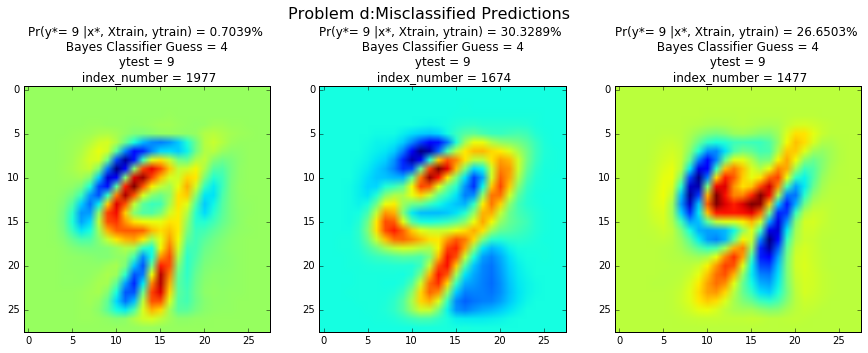

In [52]:
#Problem d
np.random.seed(4)


misclassified=ytest-y_predict
m=np.where(misclassified!=0)[1]
r=np.random.choice(m,3)

fig = plt.figure(figsize=(15,6))
fig.suptitle('Problem d:Misclassified Predictions', fontsize=16)
p={}
for i in r:
    idx=list(r).index(i)
    binary_map=np.asarray([4,9])
    classification=binary_map[y_predict[i]]
    actual=binary_map[ytest[0][i]]
    img=np.reshape(np.dot(Q, Xtest)[:,i], (28,28))
    title='Pr(y*= %s |x*, Xtrain, ytrain) = %s \n Bayes Classifier Guess = %s \n ytest = %s \n index_number = %s' %(actual, '{:.4%}'.format(pr[i]), classification, actual,i)
    p[idx]=fig.add_subplot(1,3,idx+1)
    p[idx].set_title(title, fontsize=12)
    p[idx].imshow(img)


/home/nan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


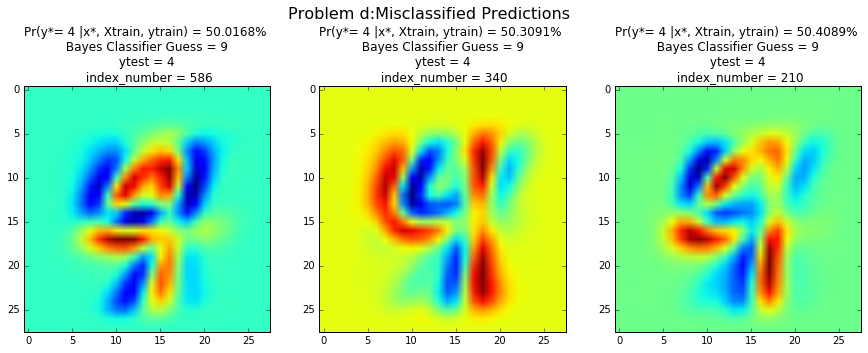

In [59]:
#Problem e
min_index = np.power(0.5-pr,2).argsort()[:3]

misclassified=ytest-y_predict
m=np.where(misclassified!=0)[1]
r=min_index

fig = plt.figure(figsize=(15,6))
fig.suptitle('Problem d:Misclassified Predictions', fontsize=16)
p={}
for i in r:
    idx=list(r).index(i)
    binary_map=np.asarray([4,9])
    classification=binary_map[y_predict[i]]
    actual=binary_map[ytest[0][i]]
    img=np.reshape(np.dot(Q, Xtest)[:,i], (28,28))
    title='Pr(y*= %s |x*, Xtrain, ytrain) = %s \n Bayes Classifier Guess = %s \n ytest = %s \n index_number = %s' %(actual, '{:.4%}'.format(pr[i]), classification, actual,i)
    p[idx]=fig.add_subplot(1,3,idx+1)
    p[idx].set_title(title, fontsize=12)
    p[idx].imshow(img)


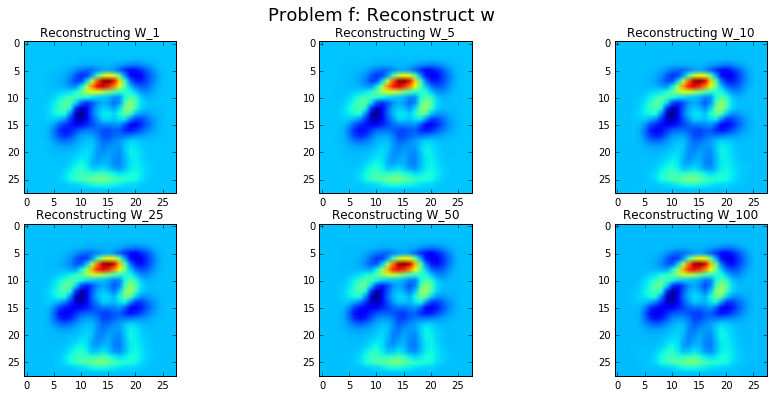

In [62]:
#Problem f
p={}
fig = plt.figure(figsize=(15,6))
fig.suptitle('Problem f: Reconstruct w', fontsize=18)
t_numbers=[1,5,10,25,50,100]
for t in t_numbers:
    idx=list(t_numbers).index(t)
    img=np.reshape(np.dot(Q, w[t]), (28,28))
    title='Reconstructing W_%s' %t
    p[idx]=fig.add_subplot(2,3,idx+1)
    p[idx].set_title(title, fontsize=12)
    p[idx].imshow(img)

In [56]:
pr.shape

(1991,)

In [57]:
min_index = np.power(0.5-pr,2).argsort()[:3]

In [58]:
min_index

array([586, 340, 210])